# Market Data

The trade data for this project is acquired from [Poloniex](https://poloniex.com) exchange, which is the number 1 crypto currency exchange by [daily volume](http://coinmarketcap.com/exchanges/volume/24-hour/). 

From Poloniex we are able to acquire [historical trade data](#Historical-Trade-Data), [real-time orderbook data](http://localhost:8888/notebooks/Orderbook%20Data.ipynb) and real-time trollbox data. We start by acquiring the historical trade data and standardizing our samples across markets. We also acquire the real-time data and save it for incorporation in the training model. 

In [211]:
import json
import time
import requests
%matplotlib inline
from pylab import *
import pandas as pd
import numpy as np
from datetime import datetime, timedelta

from IPython.core.display import HTML
HTML('<style>{}</style>'.format( open('style.css').read() ) )

** Create function for requesting Poloniex data **

In [2]:
def poloniex_api(command, args={}):
    url = 'https://poloniex.com/public?command='+command
    for arg, value in args.items():
        url += '&{}={}'.format(arg,value)
    return json.loads(requests.get(url).content.decode('utf-8'))

## Historical Trade Data
The trade data wrangling process requires that we group and standardize the time series data according to time interval. We then group our sample populations by trade type(i.e. buy or sell) and volume level (e.g. high). 



#### Top markets by daily trade volume
First, lets get the markets with the highest daily volume. To keep things simple we only look at BTC denominated markets.

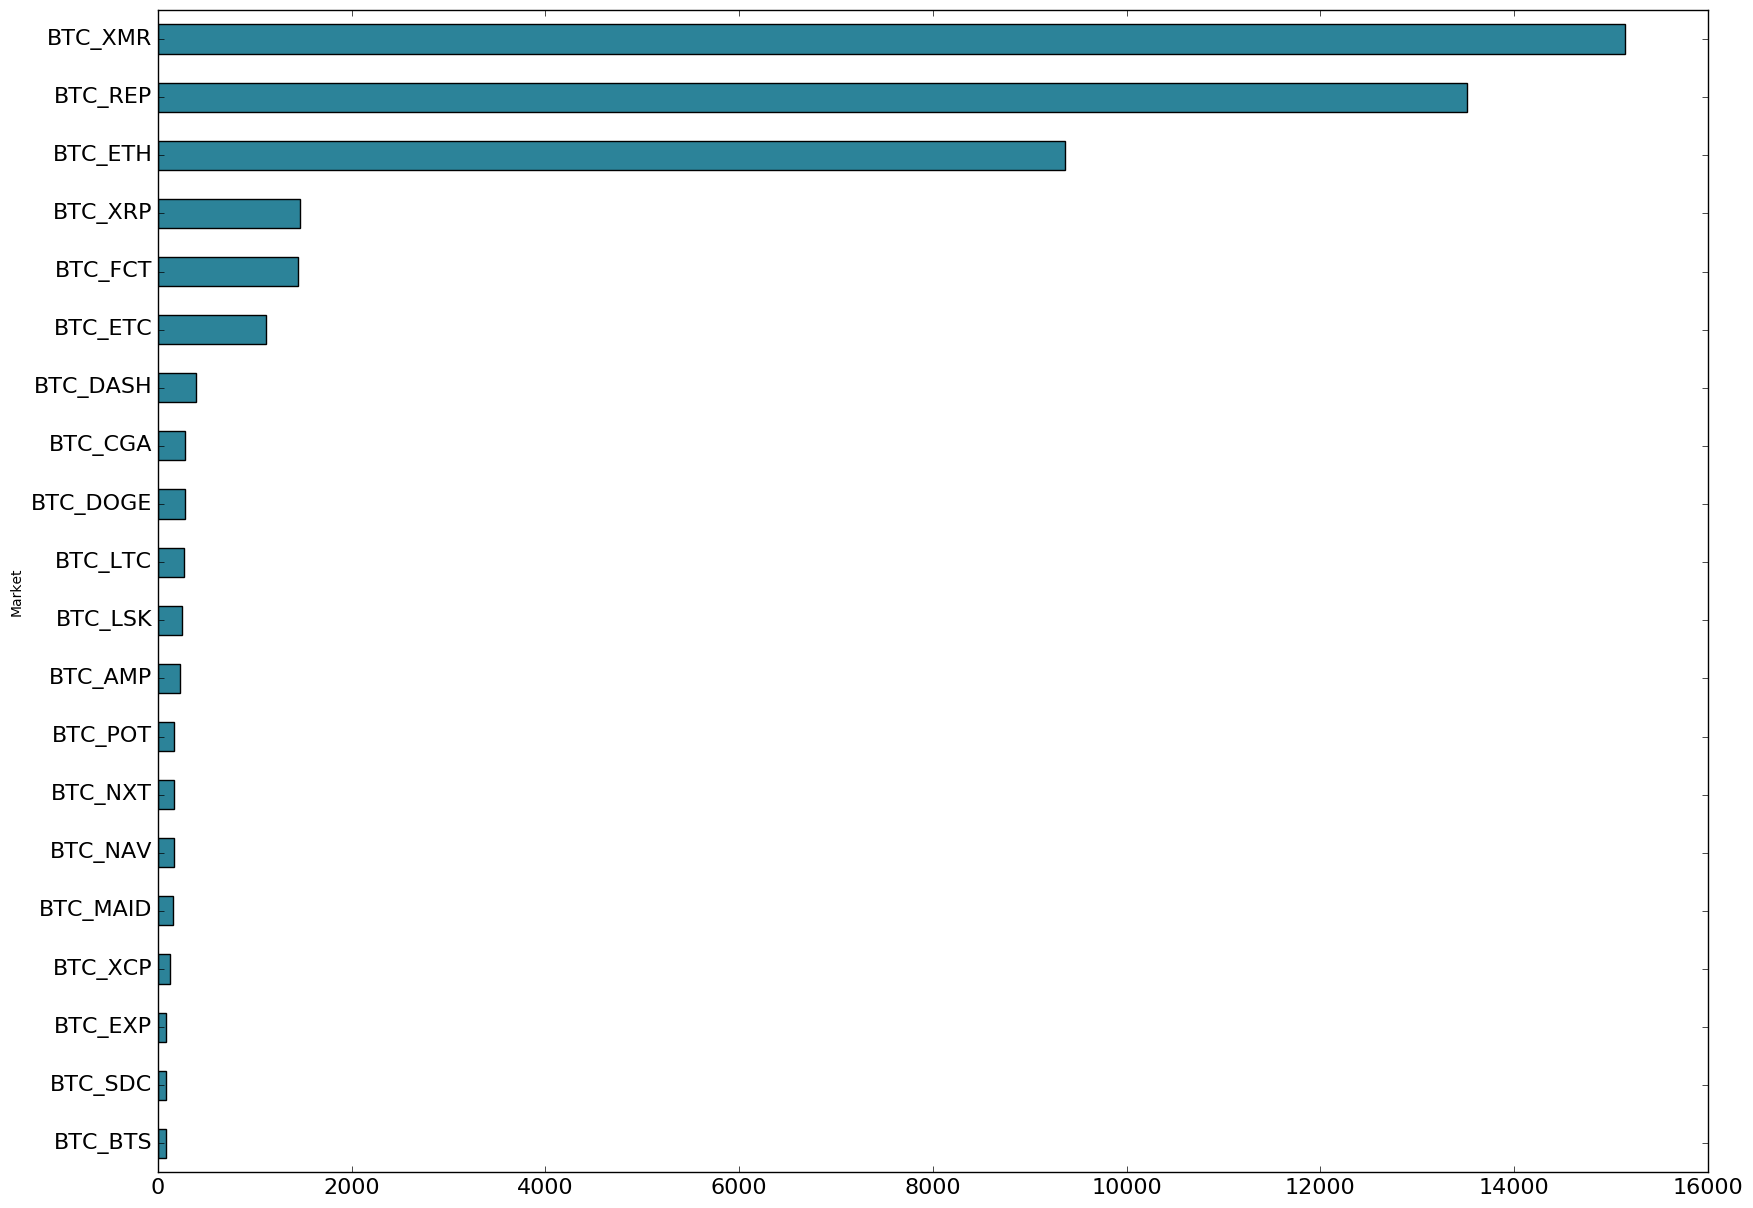

In [3]:
market_volumes = poloniex_api('return24hVolume')
btc_market_volumes = [(m, float(market_volumes[m]['BTC'])) for m in market_volumes if m[:3] == 'BTC']
top_markets = (pd.DataFrame(btc_market_volumes, columns=['Market','Volume'])
     .set_index('Market').sort_values(by='Volume', ascending=False).head(20))

top_markets.Volume.sort_values(0).plot(kind='barh', figsize=(20,15), fontsize=16, color='#2C8399')

#### Acquiring trade data

The function *get_trade* pulls trade data for a given market and from a specified period of time. If the query result is to big to keep in memory the data is requested in chuncks and saved to an output file. 

In [98]:
def unix_time(dt):
    return int(time.mktime(dt.timetuple()))

def format_dtypes(df):
    trades = df.copy()
    for col in ['amount','rate','total']:
        trades[col] = trades[col].astype(float, raise_on_error=False)
    trades['date'] = pd.to_datetime(trades.date)
    return trades
        
def get_trades(currency_pair, start, end, save_file=False, file_path='data/'):
    
    date_fmt = '%Y-%m-%dT%H:%M:%S'
    file_name = file_path+'Trades|{}|{}|{}.csv'.format(
        currency_pair, start.strftime(date_fmt), end.strftime(date_fmt))
    
    trades = pd.DataFrame()
    total_trades = len(trades)
    need_to_fetch = lambda t: len(t) == 0 or len(t) % 50000 == 0
    while need_to_fetch(trades):
        
        new_trades = pd.DataFrame(
            poloniex_api('returnTradeHistory', {
                'currencyPair': currency_pair,
                'start': unix_time(start),
                'end': unix_time(end if len(trades) == 0 
                                 else datetime.utcfromtimestamp(
                            trades.date.tail(1).values[0].tolist()/1e9))
            }))
        
        if new_trades.empty:
            break
        
        new_trades = format_dtypes(new_trades)
        
        if save_file:
            with open(file_name, 'a') as f:
                new_trades.to_csv(f, index=False)
                trades = new_trades
        else:
            trades = pd.concat([trades, new_trades])
        
        total_trades += len(new_trades)
        
        
        time.sleep(2)
    
    if save_file:
        return file_name
    
    print('acquired {} total trades'.format(total_trades))
    return trades 

### XMR trade data

XMR, which is the currency symbol for [Monero](https://getmonero.org/) has the highest trading volume of any of the BTC markets. Monero is a crypto currency that seeks to improve upon the privacy features of Bitcoin. It has recently become popular as the preferred currency for dark web transaction, which has lead to a subsequent rise in its market capitalization and trading volume.

We first acquire, normalize and analize Monero trade data during it's rise in popularity and the period of volativity following that increase price. 

From the end of August to the begininning of September the market capitalization of XMR increased from \$30 to $175 million. We therefore want to look at the trades in month preceeding that spike through September. 

In [277]:
xmr_data = get_trades('BTC_XMR', datetime(2016,8,1), datetime(2016,10,1), save_file=True)

** File Size **

In [28]:
print('{} MB'.format(os.path.getsize(xmr_data) * 1e-6))

141.67118 MB


In [100]:
xmr_trades = pd.read_csv(xmr_data)
xmr_trades.shape

(2084412, 7)

** Original Feautres **

In [101]:
xmr_trades.columns.tolist()

['amount', 'date', 'globalTradeID', 'rate', 'total', 'tradeID', 'type']

In [102]:
date = xmr_trades.head().date.values[0]
datetime.strptime(date,'%Y-%m-%d %H:%M:%S')

datetime.datetime(2016, 9, 30, 23, 58, 57)

** Add time_interval **:
We want to bucket trades by time_interval so we can create standardized timeseries data across markets

In [103]:
def time_interval(dt, delta):
    try:
        dt = datetime.strptime(dt,'%Y-%m-%d %H:%M:%S')
        return dt + (datetime.min - dt) % delta
    except:
        return np.nan

xmr_trades['time_interval'] = xmr_trades.date.apply(lambda dt: time_interval(dt, timedelta(minutes=15)))   

In [104]:
xmr_trades['time_interval'].unique()[:5]

array(['2016-10-01T00:00:00.000000000', '2016-09-30T23:45:00.000000000',
       '2016-09-30T23:30:00.000000000', '2016-09-30T23:15:00.000000000',
       '2016-09-30T23:00:00.000000000'], dtype='datetime64[ns]')

**Add volume_level**: 
We want to categorize the volume of a given trade so that we can better group trades and filter out noisy trading activity 

In [105]:
def get_volume_level(total):
    try: 
        total = float(total)
        level = 'very_low'
        if 0.2 <= total <= 1:
            level = 'low'
        elif 1 <= total <= 5:
            level = 'medium'
        elif 5 <= total <= 10:
            level = 'high'
        elif 10 <= total:
            level = 'very_high'
        return level
    except:
        return np.nan
    
xmr_trades['volume_level'] = xmr_trades.total.apply(get_volume_level)

In [106]:
xmr_trades['volume_level'].value_counts() / xmr_trades.shape[0] * 100#.sort_values(0).plot(kind='barh',figsize=(20,15), fontsize=16, color='#2C8399')

very_low     75.781851
low          13.955974
medium        8.449817
high          1.281417
very_high     0.528974
Name: volume_level, dtype: float64

More than 75% of the trades are considered very low volume. The threshold for this categorization was any trade of less than 0.2 BTC or about 125 USD. We'll first look into the 25% of the trades that had more capital behind them. 

In [133]:
xmr_trades = xmr_trades[xmr_trades.volume_level!='very_low']
xmr_trades.shape

(504806, 10)

** Group trades by time interval, type and volume level **

In [224]:
grouped_trades = xmr_trades[['type','rate','total', 'volume_level','time_interval']].dropna(how='all')
trade_stats = grouped_trades.groupby(['time_interval','type','volume_level']).describe()

** Get trade information for period when there is very high buy volume **

In [237]:
flatten_stats = trade_stats.unstack(['type','volume_level',3])#['total','buy','high','count']
large_buy_volume = flatten_stats['total','buy','high','count'] > 10

trade_counts = flatten_stats[large_buy_volume]['total','sell','medium','count']
trade_prices = flatten_stats[large_buy_volume]['rate','sell','medium','top'].astype(float)

In [257]:
high_buy = flatten_stats[large_buy_volume]

ts = {(field,t,v): (high_buy[field,t,v]['count'], high_buy[field,t,v]['top'].astype(float))
    
      for field in ['rate','total']
        for t in ['buy','sell']
            for v in ['low','medium','high','very_high']
     }

len(ts)

/home/ubuntu/anaconda3/lib/python3.5/site-packages/ipykernel/ipkernel.py:196: PerformanceWarning: indexing past lexsort depth may impact performance.
  res = shell.run_cell(code, store_history=store_history, silent=silent)


16

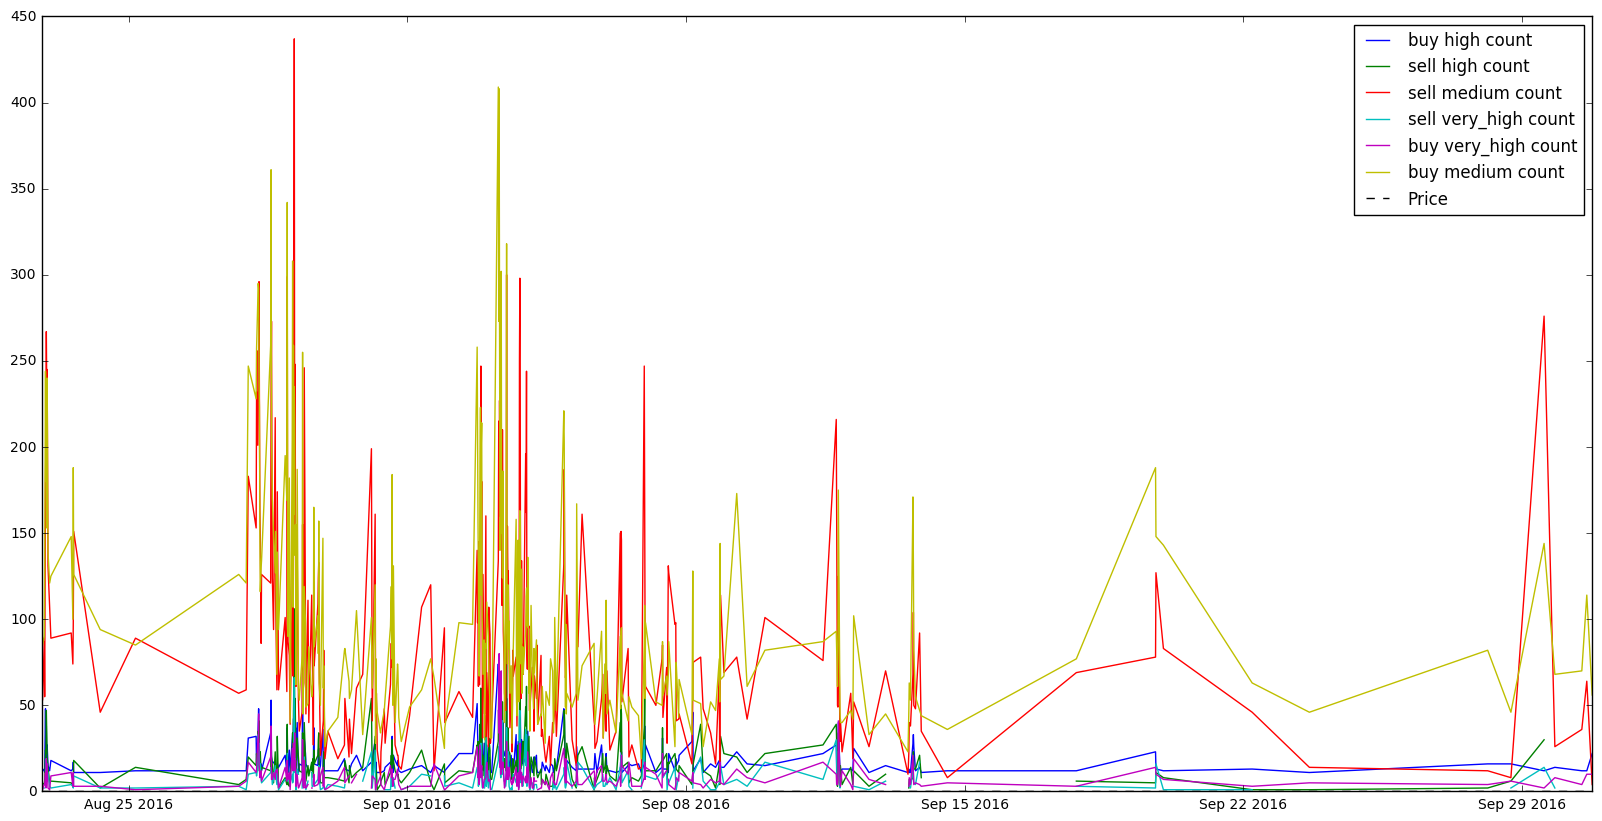

In [271]:
plt.figure(figsize=(20,10))

for group, series in ts.items():
    
    if 'rate' in group  and 'low' not in group:
        index = series[0].index
        counts = series[0].values
        means = series[1].values
        plt.plot(index, counts, label='{} count'.format(' '.join(group[1:])))
        #plt.plot(index, means, label='{} mean'.format(group))

        
plt.plot(high_buy.index, high_buy['rate','buy','low','top'].values, '--', label='Price')
plt.legend()
plt.show()

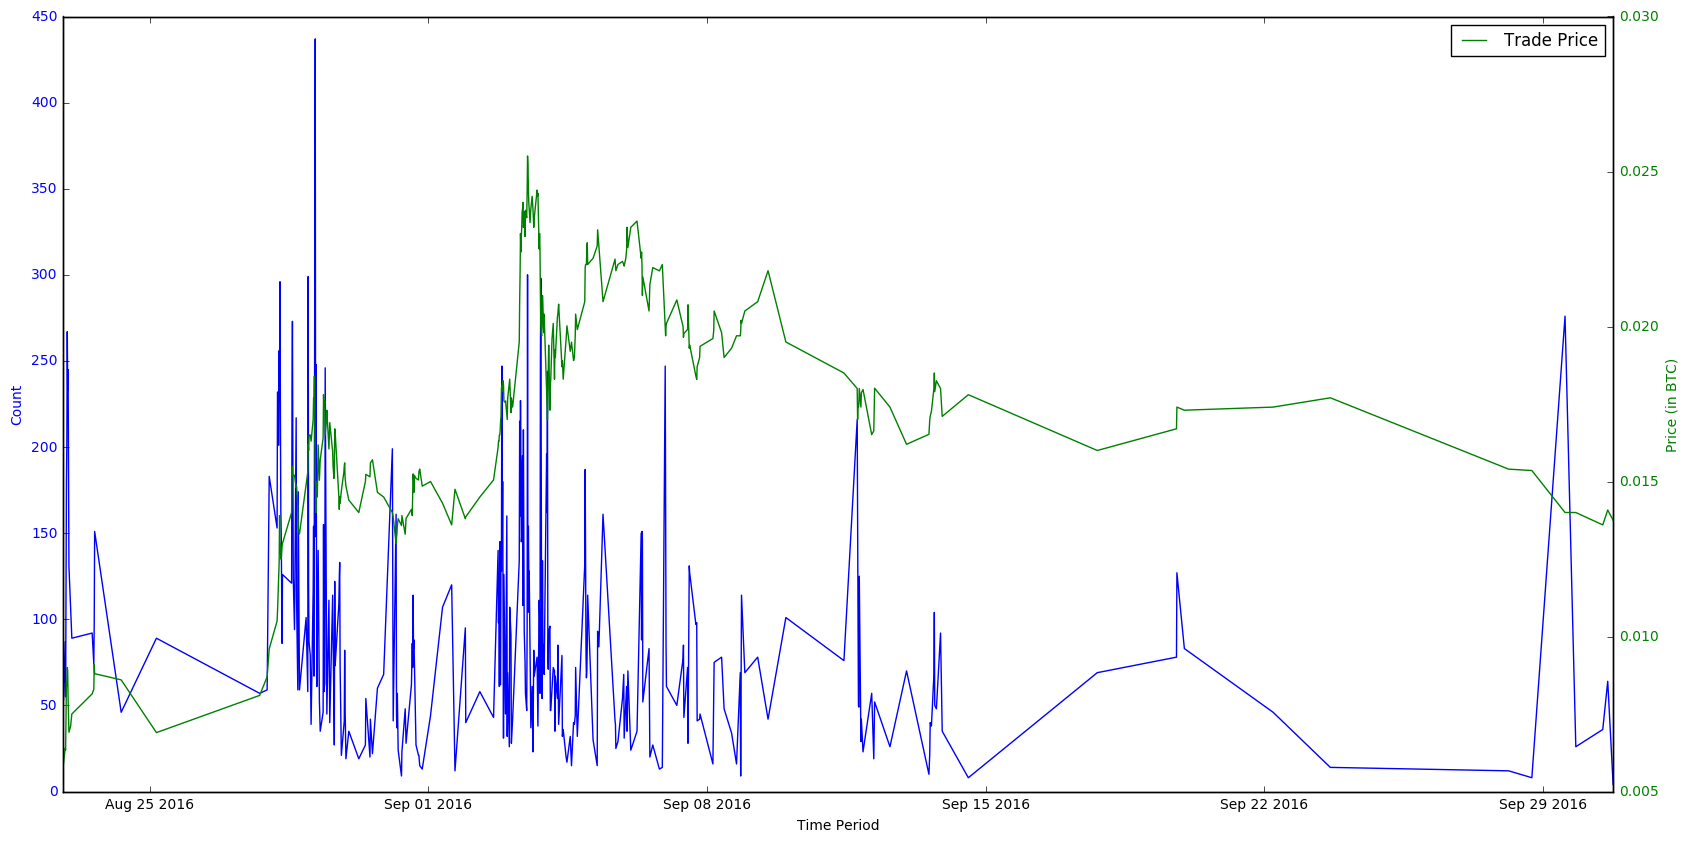

In [239]:
fig, ax1 = plt.subplots(figsize=(20,10))
ax1.plot(trade_counts.index, trade_counts.values, 'b-', color='b', label='Trade Count')
ax1.set_xlabel('Time Period')
# Make the y-axis label and tick labels match the line color.
ax1.set_ylabel('Count', color='b')
for tl in ax1.get_yticklabels():
    tl.set_color('b')


ax2 = ax1.twinx()
ax2.plot(trade_prices.index, trade_prices.values, color='g', label='Trade Price')
ax2.set_ylabel('Price (in BTC)', color='g')
for tl in ax2.get_yticklabels():
    tl.set_color('g')
    
plt.legend()
plt.show()


In [275]:
high_buy = high_buy.astype(float)
pct_change = high_buy.merge((high_buy.diff(4) / high_buy), right_index=True, left_index=True, suffixes=('_value','_pct_change'))

In [276]:
pct_change.head()

rate_value                                                \
type                      sell                           buy                   
volume_level               low                           low                   
                         count unique       top  freq  count unique      top   
time_interval                                                                  
2016-08-22 19:45:00      199.0  131.0  0.006007   6.0  303.0  129.0  0.00600   
2016-08-22 20:00:00      211.0  130.0  0.006070   9.0  277.0  131.0  0.00600   
2016-08-22 21:00:00      235.0  108.0  0.006400  26.0  309.0  127.0  0.00640   
2016-08-22 21:15:00      130.0   95.0  0.006350   5.0  372.0  184.0  0.00659   
2016-08-22 21:45:00      390.0  198.0  0.007000  14.0  561.0  262.0  0.00800   

                                        ...  total_pct_change                 \
type                        sell        ...              sell            buy   
volume_level              medium        ...         very_high           high   
                     freq  count unique ...               top freq     count   
time_interval                           ...                                    
2016-08-22 19:45:00  20.0   74.0   50.0 ...               NaN  NaN       NaN   
2016-08-22 20:00:00  11.0   53.0   35.0 ...               NaN  NaN       NaN   
2016-08-22 21:00:00  22.0   87.0   44.0 ...               NaN  NaN       NaN   
2016-08-22 21:15:00  24.0   55.0   43.0 ...               NaN  NaN       NaN   
2016-08-22 21:45:00  31.0  180.0  103.0 ...          -0.14617  0.0  0.770833   

                                                                            \
type                                                                         
volume_level                                 very_high                       
                       unique       top freq     count    unique       top   
time_interval                                                                
2016-08-22 19:45:00       NaN       NaN  NaN       NaN       NaN       NaN   
2016-08-22 20:00:00       NaN       NaN  NaN       NaN       NaN       NaN   
2016-08-22 21:00:00       NaN       NaN  NaN       NaN       NaN       NaN   
2016-08-22 21:15:00       NaN       NaN  NaN       NaN       NaN       NaN   
2016-08-22 21:45:00  0.765957 -0.168949  0.5  0.363636  0.363636  0.341791   

                          
type                      
volume_level              
                    freq  
time_interval             
2016-08-22 19:45:00  NaN  
2016-08-22 20:00:00  NaN  
2016-08-22 21:00:00  NaN  
2016-08-22 21:15:00  NaN  
2016-08-22 21:45:00  0.0  

[5 rows x 128 columns]

Classification:
    * 0: Large positive change in buy volume and price
    * 1: No change in buy volume and price
    * 2: Large negative change in buy volume and price 